In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreeshakaggle","key":"037f4b55e34b7d6831f30aece1fc22e8"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Dog_Breed_prediction
!mkdir dog_dataset

/content/drive/MyDrive/Colab Notebooks/Dog_Breed_prediction


In [ ]:
%cd dog_dataset

/content/drive/MyDrive/Colab Notebooks/Dog_Breed_prediction/dog_dataset


In [ ]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           6153          8  0.1764706        


In [ ]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 685M/691M [00:08<00:00, 77.8MB/s]
100% 691M/691M [00:09<00:00, 75.3MB/s]


In [ ]:
%cd ..

/content/drive/MyDrive/Colab Notebooks/Dog_Breed_prediction


In [ ]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam

In [14]:
data  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dog_Breed_prediction/dog_dataset/labels.csv')
data.shape

(10222, 2)

In [15]:
breed_all = data['breed']
breed_counts = breed_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [16]:
breed_counts

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

In [17]:
BREED_CLASS = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
data = data[data['breed'].isin(BREED_CLASS)]
data = data.reset_index()
data.shape

(357, 3)

In [18]:
xdata = np.zeros((len(data), 224, 224, 3), dtype='float32')
ydata = label_binarize(data['breed'], classes=BREED_CLASS)
for i in tqdm(range(len(data))):
  img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Dog_Breed_prediction/dog_dataset/train/%s.jpg' % data['id'][i], target_size = (224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  xdata[i] = x / 255.0

100%|██████████| 357/357 [00:03<00:00, 94.34it/s] 


In [19]:
xdata.shape
xdata.size

53738496

In [21]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(BREED_CLASS), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 16)       

In [22]:
xtrain_val, xtest, ytrain_val, ytest = train_test_split(xdata, ydata, test_size = 0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain_val, ytrain_val, test_size = 0.2)

In [25]:
epochs = 100
batch_size = 128

history = model.fit(xtrain, ytrain, batch_size = batch_size, epochs = epochs,
                    validation_data = (xval, yval))

Epoch 1/100
2/2 [==============================] - 57s 24s/step - loss: 4.9066 - accuracy: 0.3672 - val_loss: 4.8846 - val_accuracy: 0.3846
Epoch 2/100
2/2 [==============================] - 44s 25s/step - loss: 4.8794 - accuracy: 0.3555 - val_loss: 4.8574 - val_accuracy: 0.3846
Epoch 3/100
2/2 [==============================] - 40s 21s/step - loss: 4.8536 - accuracy: 0.3555 - val_loss: 4.8300 - val_accuracy: 0.3846
Epoch 4/100
2/2 [==============================] - 50s 26s/step - loss: 4.8285 - accuracy: 0.3555 - val_loss: 4.8028 - val_accuracy: 0.3846
Epoch 5/100
2/2 [==============================] - 46s 24s/step - loss: 4.8029 - accuracy: 0.3555 - val_loss: 4.7779 - val_accuracy: 0.3846
Epoch 6/100
2/2 [==============================] - 44s 25s/step - loss: 4.7772 - accuracy: 0.3555 - val_loss: 4.7513 - val_accuracy: 0.3846
Epoch 7/100
2/2 [==============================] - 42s 23s/step - loss: 4.7512 - accuracy: 0.3555 - val_loss: 4.7243 - val_accuracy: 0.4000
Epoch 8/100
2/2 [===

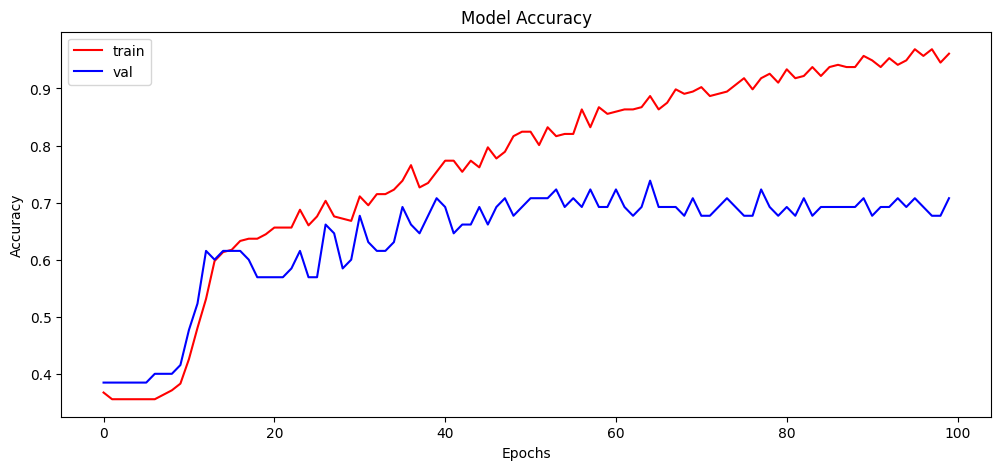

In [26]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [28]:
Y_pred = model.predict(xtest)
score = model.evaluate(xtest, ytest)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 2s 211ms/step - loss: 3.2355 - accuracy: 0.7500
Accuracy over the test set: 
  75.0 %


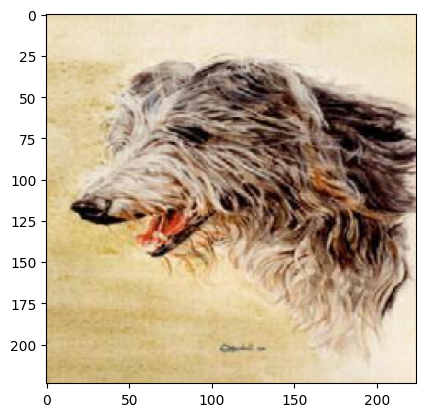

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [30]:
# Plotting image to compare
plt.imshow(xtest[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",data['breed'][np.argmax(ytest[1])])
print("Predicted : ",data['breed'][np.argmax(Y_pred[1])])